In [133]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
%matplotlib inline

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve 
from sklearn import metrics
from sklearn.metrics import (accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc, 
                             mean_squared_error, log_loss, precision_recall_curve, classification_report, 
                             precision_recall_fscore_support)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
import os

#Add Graphviz path to environment variable PATH, used for visualizing decision trees
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'


import warnings
warnings.filterwarnings("ignore")

In [102]:
def returnFeatureImportance(gbm_model, vec):
    feature_importance = gbm_model.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    featuresNames = []
    featureImps =[]
    for item in sorted_idx[::-1][:]:
        featuresNames.append(np.asarray(vec.feature_names_)[item])
        featureImps.append(feature_importance[item])
    featureImportance = pd.DataFrame([featuresNames, featureImps]).transpose()
    featureImportance.columns = ['FeatureName', 'Relative Importance']
    return featureImportance

In [115]:
def roc_plot_test(fpr, tpr):
    fig=plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC curve using test data for SIU classifier')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.grid(True)
    

In [116]:
def roc_plot_train(fpr, tpr):
    fig=plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC curve using train data for SIU classifier')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.grid(True)
 

In [46]:
# Import the data

df = pd.read_csv(r'C:\Users\hardevr609\Desktop\0911 class\heart-disease-uci\heart (2).csv')

In [47]:
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data

,Total,Percent
target,0,0.0
thal,0,0.0
ca,0,0.0
slope,0,0.0
oldpeak,0,0.0
exang,0,0.0
thalach,0,0.0
restecg,0,0.0
fbs,0,0.0
chol,0,0.0


In [48]:
# print the shape
print('The shape of the dataset : ', df.shape)

The shape of the dataset :  (303, 14)


In [49]:
# preview dataset
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [50]:
# summary of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.2 KB


In [53]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Dataset description 
The dataset contains several columns which are as follows -

age : age in years
sex : (1 = male; 0 = female)
cp : chest pain type
trestbps : resting blood pressure (in mm Hg on admission to the hospital)
chol : serum cholestoral in mg/dl
fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
restecg : resting electrocardiographic results
thalach : maximum heart rate achieved
exang : exercise induced angina (1 = yes; 0 = no)
oldpeak : ST depression induced by exercise relative to rest
slope : the slope of the peak exercise ST segment
ca : number of major vessels (0-3) colored by flourosopy
thal : 3 = normal; 6 = fixed defect; 7 = reversable defect
target : 1 or 0

Important points about dataset 
sex is a character variable. Its data type should be object. But it is encoded as (1 = male; 0 = female). So, its data type is given as int64.

Same is the case with several other variables - fbs, exang and target.

fbs (fasting blood sugar) should be a character variable as it contains only 0 and 1 as values (1 = true; 0 = false). As it contains only 0 and 1 as values, so its data type is given as int64.

exang (exercise induced angina) should also be a character variable as it contains only 0 and 1 as values (1 = yes; 0 = no). It also contains only 0 and 1 as values, so its data type is given as int64.

target should also be a character variable. But, it also contains 0 and 1 as values. So, its data type is given as int64.

In [51]:
df['target'].nunique()

2

In [54]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Visualize frequency distribution of target variable

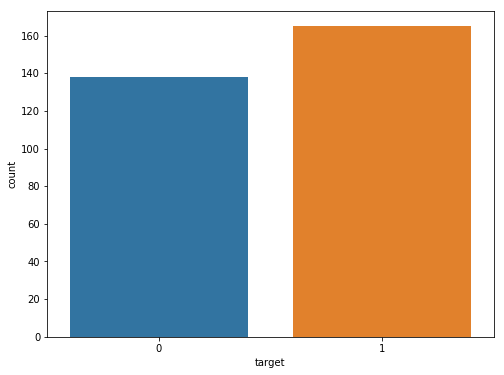

In [55]:
f, ax = plt.subplots(figsize=(8, 6))
ax = sns.countplot(x="target", data=df)
plt.show()

We can visualize the value counts of the sex variable wrt target as follows -

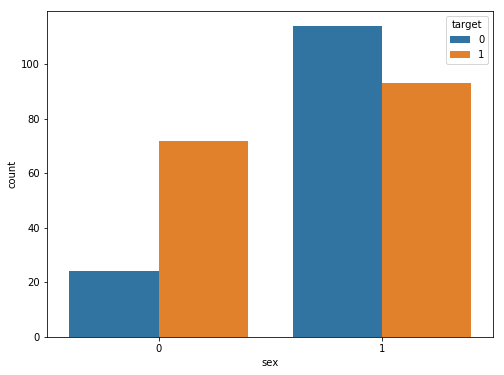

In [56]:
f, ax = plt.subplots(figsize=(8, 6))
ax = sns.countplot(x="sex", hue="target", data=df)
plt.show()

Alternatively, we can visualize the same information as follows :

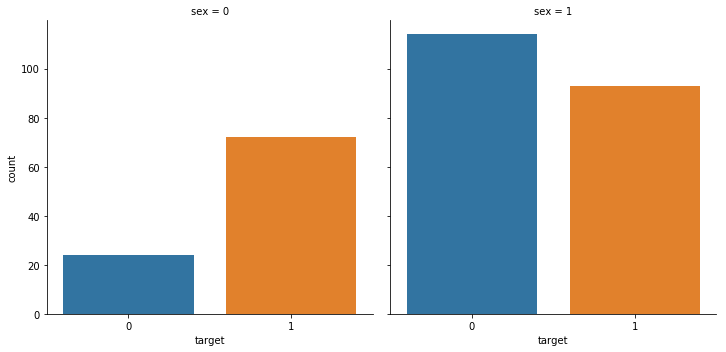

In [57]:
ax = sns.catplot(x="target", col="sex", data=df, kind="count", height=5, aspect=1)

We can use a different color palette as follows :

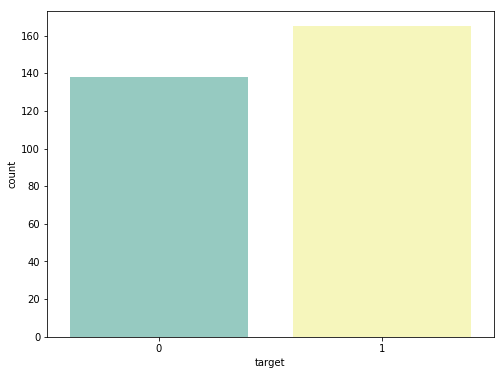

In [58]:
f, ax = plt.subplots(figsize=(8, 6))
ax = sns.countplot(x="target", data=df, palette="Set3")
plt.show()

Visualize the frequency distribution of cp variable

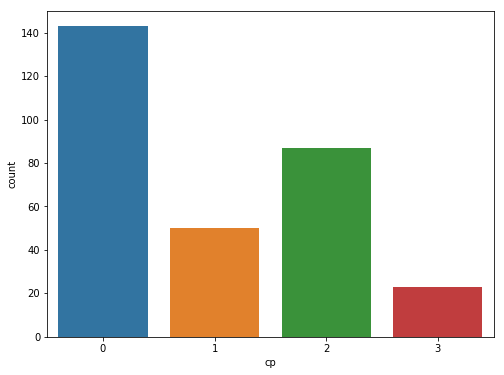

In [59]:
f, ax = plt.subplots(figsize=(8, 6))
ax = sns.countplot(x="cp", data=df)
plt.show()

In [60]:
correlation = df.corr()

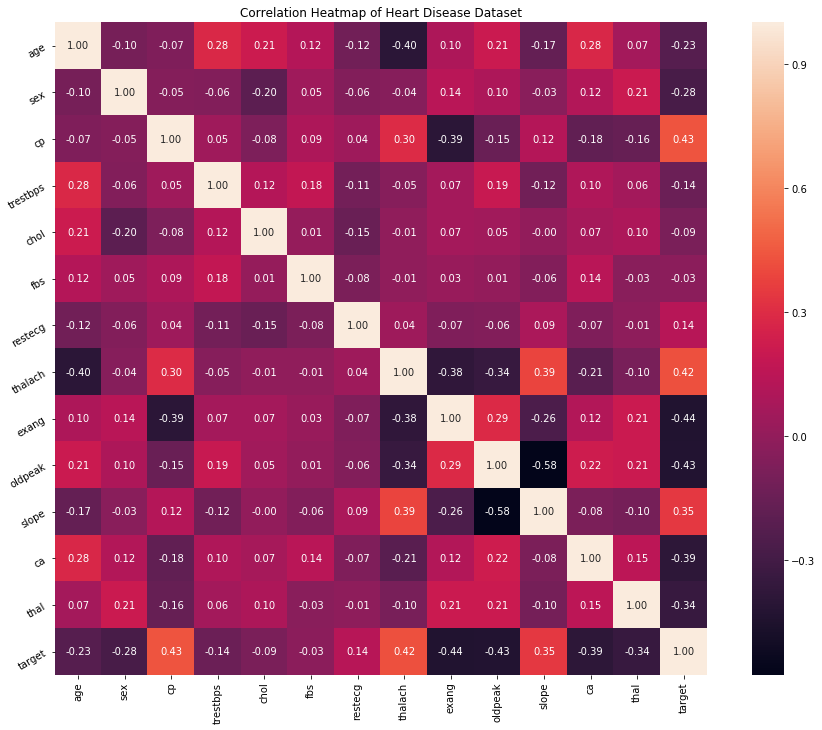

In [61]:
plt.figure(figsize=(16,12))
plt.title('Correlation Heatmap of Heart Disease Dataset')
a = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
a.set_xticklabels(a.get_xticklabels(), rotation=90)
a.set_yticklabels(a.get_yticklabels(), rotation=30)           
plt.show()

Pair Plot

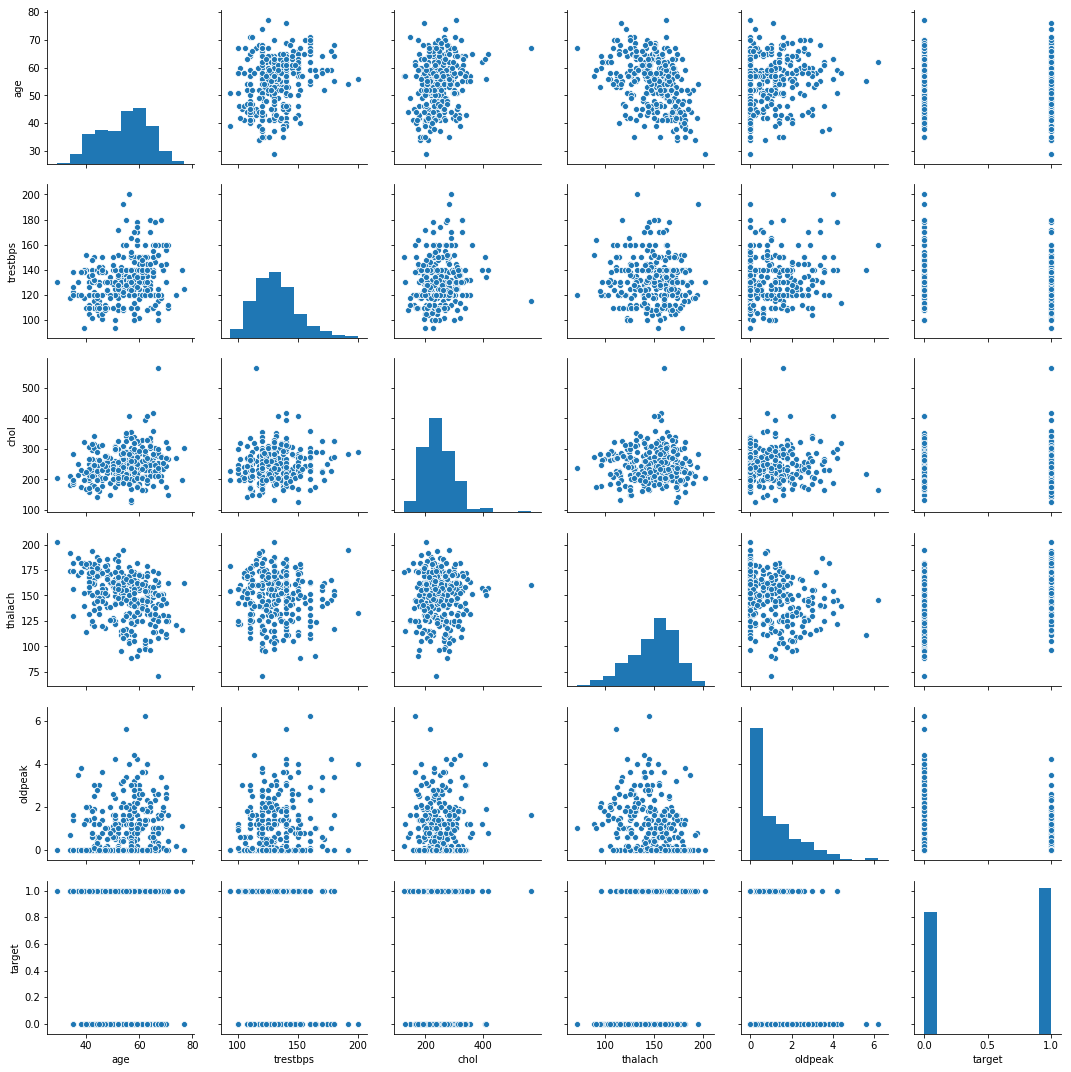

In [63]:
num_var = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'target' ]
sns.pairplot(df[num_var], kind='scatter', diag_kind='hist')
plt.show()

In [64]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [65]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [66]:
df.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 
              'rest_ecg', 'max_heart_rate_achieved', 'exercise_induced_angina', 'st_depression', 'st_slope', 
              'num_major_vessels', 'thalassemia', 'target']

df['sex'][df['sex'] == 0] = 'female'
df['sex'][df['sex'] == 1] = 'male'

df['chest_pain_type'][df['chest_pain_type'] == 1] = 'typical angina'
df['chest_pain_type'][df['chest_pain_type'] == 2] = 'atypical angina'
df['chest_pain_type'][df['chest_pain_type'] == 3] = 'non-anginal pain'
df['chest_pain_type'][df['chest_pain_type'] == 4] = 'asymptomatic'

df['fasting_blood_sugar'][df['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
df['fasting_blood_sugar'][df['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

df['rest_ecg'][df['rest_ecg'] == 0] = 'normal'
df['rest_ecg'][df['rest_ecg'] == 1] = 'ST-T wave abnormality'
df['rest_ecg'][df['rest_ecg'] == 2] = 'left ventricular hypertrophy'

df['exercise_induced_angina'][df['exercise_induced_angina'] == 0] = 'no'
df['exercise_induced_angina'][df['exercise_induced_angina'] == 1] = 'yes'

df['st_slope'][df['st_slope'] == 1] = 'upsloping'
df['st_slope'][df['st_slope'] == 2] = 'flat'
df['st_slope'][df['st_slope'] == 3] = 'downsloping'

df['thalassemia'][df['thalassemia'] == 1] = 'normal'
df['thalassemia'][df['thalassemia'] == 2] = 'fixed defect'
df['thalassemia'][df['thalassemia'] == 3] = 'reversable defect'

In [67]:
df.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
0,63,male,non-anginal pain,145,233,greater than 120mg/ml,normal,150,no,2.3,0,0,normal,1
1,37,male,atypical angina,130,250,lower than 120mg/ml,ST-T wave abnormality,187,no,3.5,0,0,fixed defect,1
2,41,female,typical angina,130,204,lower than 120mg/ml,normal,172,no,1.4,flat,0,fixed defect,1
3,56,male,typical angina,120,236,lower than 120mg/ml,ST-T wave abnormality,178,no,0.8,flat,0,fixed defect,1
4,57,female,0,120,354,lower than 120mg/ml,ST-T wave abnormality,163,yes,0.6,flat,0,fixed defect,1


### Convert categorical variable into dummy/indicator variables
Since some Classifier algorithms do not accept categorical fields, they need to be transformed
There are two methods for transforming categorical fields: <br>

<b>1. Label encoding</b> - each unique category value is assigned an integer value<br>
<b>2. One Hot encoding</b> - the integer encoded variable is removed and a new binary variable is added for each unique integer value

The first one is not preferred since the classification algorithms tend to assume a natural ordering between categories, which may result in poor performance or unexpected results

__One Hot encoding using get_dummies__

In [80]:
X_with_dummy_features = pd.get_dummies(X,drop_first=True)
y_with_dummy_features = pd.get_dummies(y,drop_first=True)

### Splitting into train and test datasets

A better way to test a model is to use a hold-out set which doesn't enter the training. This operation can be performed using scikit-learn's train/test split utility:
<cite>
<b>Stratified sampling</b> is a probability sampling technique; to divide the entire population into different subgroups or strata, then randomly selects the final subjects proportionally from the different strata.</cite>

In [81]:
xtrain, xtest, ytrain, ytest  = train_test_split \
                (X_with_dummy_features, y_with_dummy_features,test_size=0.5, \
                stratify=y_with_dummy_features,random_state=1000)
print ("No. of True Cases in training data set for" , ytrain.values.ravel().sum())
print ("No. of True Cases in testing data set for",ytest.values.ravel().sum())

print ("Ratio of True Cases in training data set: " , round(ytrain.values.ravel().sum()/len(ytrain.values.ravel()),2))
print ("Ratio of True Cases in testing data set: ", round(ytest.values.ravel().sum()/len(ytest.values.ravel()),2))

No. of True Cases in training data set for 82
No. of True Cases in testing data set for 83
Ratio of True Cases in training data set:  0.54
Ratio of True Cases in testing data set:  0.55


## Model training and evaluation of different classifiers

### Logistic Regression

<cite>
<b>Logistic regression</b> is an easy to interpret and computationally inexpensive classification algorithm. It uses the natural logarithm function to find the relationship between the variables and uses test data to find the coefficients.</cite>
* Benefits - Easy to interpret
* Limitations - Performs poorly with non-linear relationships, suffers because of outliers

In [154]:
#initialize model performance comparison dataframe
eval_results_compare = pd.DataFrame()

In [155]:
model_name = 'Logistic Regression'
logreg = LogisticRegression()
trained_model_lr = logreg.fit(xtrain, ytrain.values.ravel())

In [156]:
print ("Trained model :: ", trained_model_lr)

Trained model ::  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


In [157]:
prob_test  = trained_model_lr.predict_proba(xtest)
prob_train = trained_model_lr.predict_proba(xtrain)

#Probability Threshold = 0.5 (default) 
pred_test  = trained_model_lr.predict(xtest)
pred_train = trained_model_lr.predict(xtrain)

In [158]:
pd.DataFrame(prob_test).to_csv('prob_test.csv')

Lift plot for validation Sample


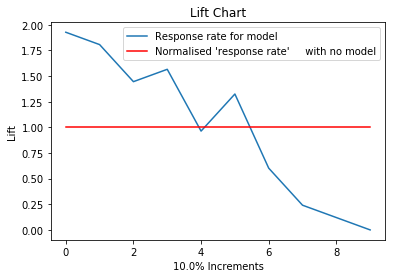

ROC curve for the validaton Sample


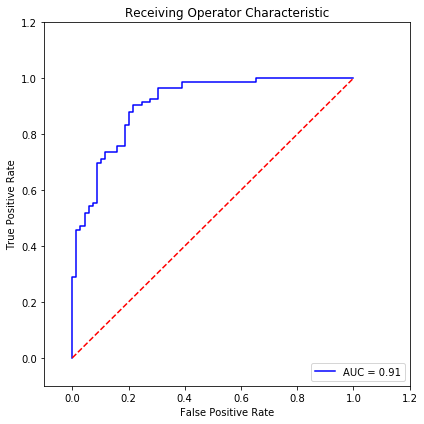

<Figure size 432x432 with 0 Axes>

In [159]:
#Calculate key performance metrics for model validation
eval_result_LR = evaluate_model(model_name, trained_model_lr, xtrain, xtest, ytrain, ytest, verbose = False)

#Append key performance metrics to comparison dataframe
eval_results_compare = eval_results_compare.append(eval_result_LR)
eval_results_compare.reset_index(drop=True,inplace=True)

<cite><b>AUC Score</b></cite> (Area under the Curve)
- Metric to calculate the overall performance of a classification model based on area under the ROC curve

In [160]:
#Calculate AUC
auc_score = roc_auc_score(ytest, prob_test[:,1])
print ("\n\nModel ROC-AUC score for validation sample: %.3f" \
                                      % auc_score)



Model ROC-AUC score for validation sample: 0.909


<cite><b>Train and test Accuracy</b></cite>
 - Accuracy is the fraction of predictions correctly predicted by the classifier

In [161]:
#Calculate train and test accuracy
train_acc = accuracy_score(ytrain.values.ravel(), pred_train)
test_acc  = accuracy_score(ytest.values.ravel(), pred_test)
print ("\nTrain Accuracy :: ", train_acc)
print ("\nTest Accuracy :: ", test_acc)


Train Accuracy ::  0.8410596026490066

Test Accuracy ::  0.8486842105263158


<cite><b>Confusion matrix</b></cite>
- A confusion matrix is a 2x2 contingency table that is used to describe the performance of a classification model on a set of test data for which the true values are known.

In [162]:
from sklearn.metrics import confusion_matrix

In [163]:
confusion_matrix(ytest, pred_test)

array([[54, 15],
       [ 8, 75]], dtype=int64)

<cite><b>Precision, recall, F1-score</b></cite>

- <b>Recall</b>: Proportion of actual positives (TP + FN) that were identified correctly (TP) --> TP / (TP + FN)

- <b>Precision</b>: Proportion of positive identifications (TP + FP) that were actually correct (TP) --> TP / (TP + FP)

- <b>F1 score</b>: single metric that combines recall and precision using the harmonic mean
- To calculate the average, a macro <b>weighted average</b> is used, based on the number of instances for each label
- Weighted average gives a better average for an imbalanced dataset, but the impact of the less frequent class is muted
- The <b>precision - recall</b> curve, along with the ROC curve, can be used to select an <b>optimal threshold</b> cut-off, based on the business objective of the predictive classifier

In [164]:
#Calculate classification model evaluation metrics like precision, recall, f1 score
report = classification_report(ytest, pred_test)
precision,recall,fscore,support = precision_recall_fscore_support(ytest,pred_test,average='weighted')
print("\n Classification report (weighted average across classes) ::\n", classification_report(ytest, pred_test))


 Classification report (weighted average across classes) ::
               precision    recall  f1-score   support

           0       0.87      0.78      0.82        69
           1       0.83      0.90      0.87        83

    accuracy                           0.85       152
   macro avg       0.85      0.84      0.85       152
weighted avg       0.85      0.85      0.85       152



__Observation:__
* We can see that the weighted average is skewed towards the majority class, thus we will use the precision, recall and f1-score of the positive (minor) class for further model evaluations
* Probability threshold used: 0.5 (default)

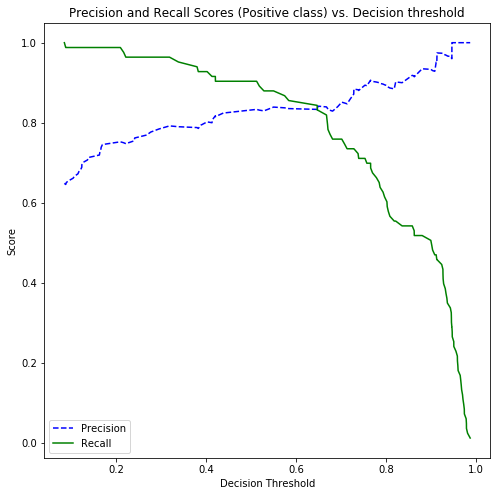

In [165]:
#Obtain the precision and recall for the corresponding variations in threshold
p, r, thresholds = precision_recall_curve(ytest, prob_test[:,1])

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    """
   
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores (Positive class) vs. Decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

plot_precision_recall_vs_threshold(p, r, thresholds)
plt.show()

In [166]:
def charac(actual, pred):
    #accuracy of the model
    
    res_1=np.column_stack((actual, pred))
    y_1=res_1[res_1[:,0]==1]
    y_0=res_1[res_1[:,0]==0]
    y_1_i=y_1[:,0]
    y_1_j=y_1[:,1]
    y_0_i=y_0[:,0]
    y_0_j=y_0[:,1]
    acc_0=metrics.accuracy_score(y_0_i, y_0_j)
    acc_1=metrics.accuracy_score(y_1_i, y_1_j)
     

    
    acc=metrics.accuracy_score(actual, pred)
    
    
    #Null accuracy of the model. Accuracy should be much higher than Null accuracy
    n_acc=max(actual.mean(), 1 - actual.mean())
    
    
    #Confusion Matrix
    confusion= metrics.confusion_matrix(actual, pred)
    
    
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    
    #misclassification rate
    mis= (FP + FN) / float(TP + TN + FP + FN)
    
    
    #sensitivity or re-call score or true positive rate
    sensitivity=metrics.recall_score(actual, pred)
    
    
    #specificity
    specificity= TN / float(TN + FP)
    
    
    #false positive rate=1-specificity
    fpr=1-specificity
    
    
    #False negative rate
    fnr= FN/(FN+TP)
    
    
    #F1 score
    f1= 2*TP/((2*TP)+FP+FN)
    
    
    #Precision
    precision= TP / float(TP + FP)
    
    
    #Precision_0
    precision_0= TN / float(TN + FN)
    
    
    #Area under curve for test
    AUC_test = roc_auc_score(actual, pred)
    

    return acc_0, acc_1, acc, n_acc, confusion, mis, sensitivity, specificity, fpr, fnr, f1, precision,precision_0, AUC_test


In [167]:
train_pred = logreg.predict(xtrain)
test_pred = logreg.predict(xtest)
train_pred_prob = logreg.predict_proba(xtrain)[:,1]
test_pred_prob = logreg.predict_proba(xtest)[:,1]

In [168]:
ytest.shape

(152, 1)

In [169]:
test_pred_class

array([1.])

In [170]:
from sklearn.preprocessing import binarize

In [171]:
test_pred_class = binarize(test_pred_prob.reshape(-1,1), 0.5)[0]
train_pred_class = binarize(train_pred_prob.reshape(-1,1), 0.5)[0]

#Calculating false positive rate, true positive rate for different threshold values. All values between 0 to 1
false_pos_rate, true_pos_rate, thresholds = metrics.roc_curve(ytest, test_pred_prob, pos_label=1)
false_pos_rate_tr, true_pos_rate_tr, thresholds_tr = metrics.roc_curve(ytrain, train_pred_prob, pos_label=1)



#calculating different characteriestics of the model
acc_0, acc_1, acc, n_acc, confusion, mis, sensitivity, specificity, fpr, fnr, f1, precision,precision_0, AUC_test= charac(np.asarray(ytest) , test_pred)

acc_0_tr, acc_1_tr, acc_tr, n_acc_tr, confusion_tr, mis_tr, sensitivity_tr, specificity_tr, fpr_tr, fnr_tr, f1_tr, precision_tr, precision_0_tr, AUC_train= charac(np.asarray(ytrain), train_pred)


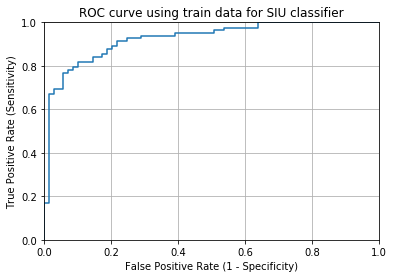

In [172]:
#plotting ROC Curve for train2
roc_plot_train(false_pos_rate_tr, true_pos_rate_tr)

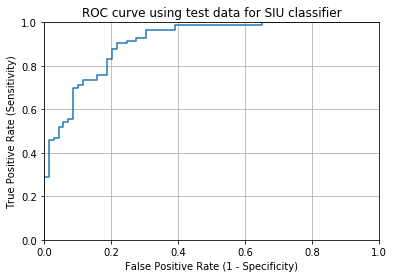

In [173]:
#plotting ROC Curve for test
roc_plot_test(false_pos_rate, true_pos_rate)


In [174]:
print ("\n\n Test Metrics :\n\n")

print ("Average Accuracy of the test model is: ", acc)
print ("Accuracy of the test model for class 0 is: ", acc_0)
print ("Accuracy of the test model for class 1 is: ", acc_1)


print ("Null Accuracy of the test model is: ", n_acc)

print ("Confusion matrix of the test model is: ", confusion)

print ("misclassification rate for test is ",  mis)

print ("recall score for Test is: ", sensitivity)

print ("specificity for Test is: ", specificity)

print ("false positive rate for Test is: ", fpr)

print ("false negative rate for Test  is: ", fnr)

print ("F1 score for Test is: ", fnr)

print ("Precision for Test is ", precision)

print ("Precision_0 for Test is ", precision_0)

print ("Test AUC using confusion matrix is: %.6f" % AUC_test)


print ("\n\n Train Metrics :\n\n")

print ("Average Accuracy of the test model is: ", acc_tr)
print ("Accuracy of the test model for class 0 is: ", acc_0_tr)
print ("Accuracy of the test model for class 1 is: ", acc_1_tr)

print ("Null Accuracy of the Train model is: ", n_acc_tr)

print ("Confusion matrix of the Train model is: ", confusion_tr)

print ("misclassification rate for Train is ",  mis_tr)

print ("recall score for Train is: ", sensitivity_tr)

print ("specificity for Train is: ", specificity_tr)

print ("false positive rate for Train is: ", fpr_tr)

print ("false negative rate for Train  is: ", fnr_tr)

print ("F1 score for Train is: ", fnr_tr)

print ("Precision for Train is ", precision_tr)

print ("Precision_0 for Train is ", precision_0_tr)

print ("Train AUC using confusion matrix is: %.6f" % AUC_train)


AUC_test_plot = roc_auc_score(ytest, test_pred_prob)
print ("Test AUC from the ROC plot is: %.6f" % AUC_test_plot)
AUC_train_plot = roc_auc_score(ytrain, train_pred_prob)
print ("Train AUC from the ROC plot is: %.6f" % AUC_train_plot)



 Test Metrics :


Average Accuracy of the test model is:  0.8486842105263158
Accuracy of the test model for class 0 is:  0.782608695652174
Accuracy of the test model for class 1 is:  0.9036144578313253
Null Accuracy of the test model is:  0.5460526315789473
Confusion matrix of the test model is:  [[54 15]
 [ 8 75]]
misclassification rate for test is  0.1513157894736842
recall score for Test is:  0.9036144578313253
specificity for Test is:  0.782608695652174
false positive rate for Test is:  0.21739130434782605
false negative rate for Test  is:  0.0963855421686747
F1 score for Test is:  0.0963855421686747
Precision for Test is  0.8333333333333334
Precision_0 for Test is  0.8709677419354839
Test AUC using confusion matrix is: 0.843112


 Train Metrics :


Average Accuracy of the test model is:  0.8410596026490066
Accuracy of the test model for class 0 is:  0.7971014492753623
Accuracy of the test model for class 1 is:  0.8780487804878049
Null Accuracy of the Train model is:  0.543046357

In [175]:
model_name = 'Decision Tree'
dt=DecisionTreeClassifier()
trained_model_dt = dt.fit(xtrain,ytrain)

In [176]:
#Import supporting functions
from calculate_model_metrics import lift_plot_model, plot_roc, plot_grid_search, evaluate_model

#### Visualizing the decision tree

In [177]:

# dot_data = StringIO()

# export_graphviz(trained_model_dt, out_file=dot_data, 
#                 feature_names = xtrain.columns,
#                 max_depth = 3,
#                 class_names = ['0','1'],
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)

# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

__Model Performance Validation:__

Lift plot for validation Sample


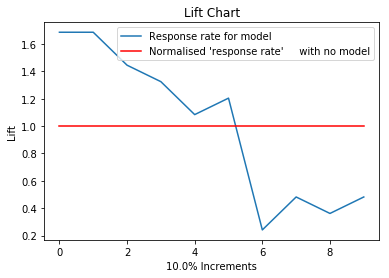

ROC curve for the validaton Sample


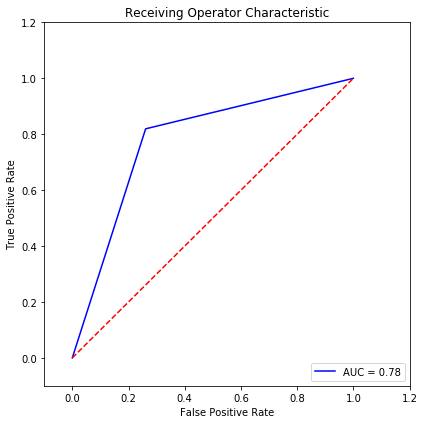

<Figure size 432x432 with 0 Axes>

In [178]:
#Calculate key performance metrics for model validation
eval_result_DT = evaluate_model(model_name, trained_model_dt, xtrain, xtest, ytrain, ytest, verbose = False)

#Append key performance metrics to comparison dataframe
eval_results_compare = eval_results_compare.append(eval_result_DT)
eval_results_compare.reset_index(drop=True,inplace=True)

In [180]:
eval_results_compare.reset_index(drop = True)

,Model,AUC,Test Accuracy,Recall_1,Precision_1,F1 Score_1,Log loss,Decile_1 Lift %,Decile_2 Lift %
0,Logistic Regression,0.909202,0.848684,0.903614,0.833333,0.867052,0.368731,1.92771,1.80723
1,Decision Tree,0.779204,0.782895,0.819277,0.790698,0.804734,7.498645,1.68675,1.68675


__Model Performance Observations:__
- Decision tree performs bestter than other models overall with respect to Recall, Precision and Accuracy

### Random Forest

<cite>
    <b>Random Forest</b> is a flexible, easy to use machine learning algorithm that produces, a great result most of the time. Random forest builds multiple decision trees and merges them together to get a more accurate and stable prediction</cite>

* Benefits - Reduces variances and avoids overfitting, robus and accurate
* Limitations - large number of trees may slow down perormance, less interpretability

In [181]:
# Create random forest classifier model to predict chrun
model_name = 'Random Forest'
clf = RandomForestClassifier()
trained_model_rf = clf.fit(xtrain, ytrain.values.ravel())

#### Saving and loading the model

In [183]:
# save the model to disk
filename = 'baseline_randomforest_model.sav'
pickle.dump(trained_model_rf, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
trained_model_rf = pickle.load(open(filename, 'rb'))

__Model Performance Validation:__

Lift plot for validation Sample


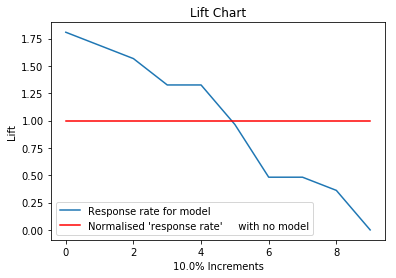

ROC curve for the validaton Sample


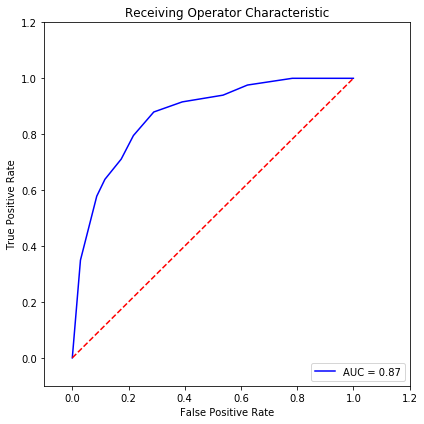

<Figure size 432x432 with 0 Axes>

In [184]:
#Calculate key performance metrics for model validation
eval_result_RF = evaluate_model(model_name, trained_model_rf, xtrain, xtest, ytrain, ytest, verbose = False)

In [185]:
#Append model results to a comparison dataframe
eval_results_compare = eval_results_compare.append(eval_result_RF)

In [186]:
eval_results_compare.reset_index(drop = True)

,Model,AUC,Test Accuracy,Recall_1,Precision_1,F1 Score_1,Log loss,Decile_1 Lift %,Decile_2 Lift %
0,Logistic Regression,0.909202,0.848684,0.903614,0.833333,0.867052,0.368731,1.92771,1.80723
1,Decision Tree,0.779204,0.782895,0.819277,0.790698,0.804734,7.498645,1.68675,1.68675
2,Random Forest,0.865811,0.802632,0.879518,0.784946,0.829545,0.858256,1.80723,1.68675


__Model Performance Observations:__
- Random Forest has high performance in Accuracy and Precision, but not in Recall. Tuning is required
- We will try to tune the parameters and decision threshold for Random forest in the following section

### Gradient Boosting Classifier
<cite>
    <b>Gradient boosting</b> is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. </cite>
    
* Benefits - Generally performs extremely well, Robust to outliers, scalable and smaller datasets
* Limitations - Harder to tune, training takes longer because of sequential ensembling

In [187]:
model_name = 'Gradient Boosting Classifier'
grb = GradientBoostingClassifier()
trained_model_grb = grb.fit(xtrain,ytrain.values.ravel())

__Model Performance Validation:__

Lift plot for validation Sample


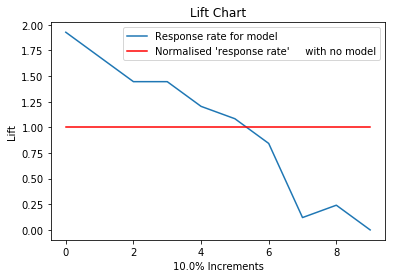

ROC curve for the validaton Sample


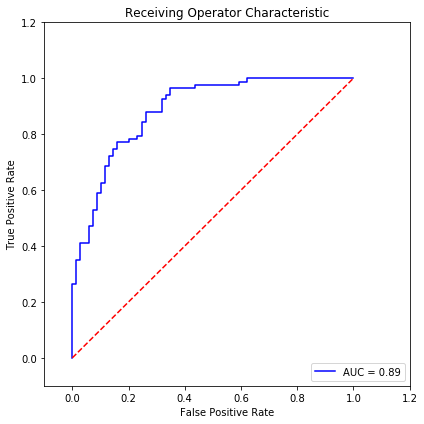

<Figure size 432x432 with 0 Axes>

In [188]:
#Calculate key performance metrics for model validation
eval_result_GRB = evaluate_model(model_name, trained_model_grb, xtrain, xtest, ytrain, ytest, verbose = False)

#Append key performance metrics to comparison dataframe
eval_results_compare = eval_results_compare.append(eval_result_GRB)
eval_results_compare.reset_index(drop=True,inplace=True)

In [189]:
eval_results_compare.reset_index(drop = True)

,Model,AUC,Test Accuracy,Recall_1,Precision_1,F1 Score_1,Log loss,Decile_1 Lift %,Decile_2 Lift %
0,Logistic Regression,0.909202,0.848684,0.903614,0.833333,0.867052,0.368731,1.92771,1.80723
1,Decision Tree,0.779204,0.782895,0.819277,0.790698,0.804734,7.498645,1.68675,1.68675
2,Random Forest,0.865811,0.802632,0.879518,0.784946,0.829545,0.858256,1.80723,1.68675
3,Gradient Boosting Classifier,0.887026,0.815789,0.879518,0.802198,0.839080,0.477401,1.92771,1.68675


__Model Performance Observations:__
- Gradient Boosting Classifier has a high overall performance

### XGBoost
<cite>
    <b>XGBoost</b> is an implementation of gradient boosted decision trees designed for speed and performance. It is a scalable and accurate implementation of gradient boosting machines and it has proven to push the limits of computing power for boosted trees algorithms as it was built and developed for the sole purpose of model performance and computational speed </cite>
   
Parameters used:
- objective = 'binary:logistic': Outputs probability for two classes
- eval_metric = 'error': Evaluation metrics for validation data, error = (# wrong cases) / (# all cases)

* <b>Benefits</b>     - Fast, efficient, scalable and flexible
* <b>Limitations</b>  - Black box, low interpretability

In [190]:
model_name = 'XGBoost'
xgb = XGBClassifier(objective = 'binary:logistic', eval_metric="error")
trained_model_xgb = xgb.fit(xtrain,ytrain.values.ravel())

__Model Performance Validation:__

Lift plot for validation Sample


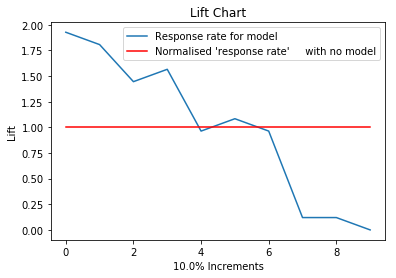

ROC curve for the validaton Sample


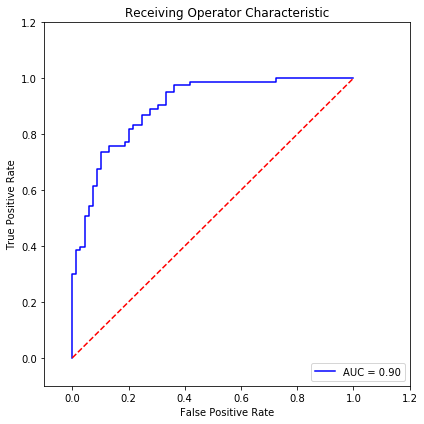

<Figure size 432x432 with 0 Axes>

In [191]:
#Calculate key performance metrics for model validation
eval_result_XGB = evaluate_model(model_name, trained_model_xgb, xtrain, xtest, ytrain, ytest, verbose = False)

#Append key performance metrics to comparison dataframe
eval_results_compare = eval_results_compare.append(eval_result_XGB)
eval_results_compare.reset_index(drop=True,inplace=True)

__Model Performance Observations:__
- XGBoost has similar performance to Gradient Boosting Classifier
- We will explore which model to choose from amongst XGBoost and Gradient Boosting Classifier in a following section

In [193]:
eval_results_compare.reset_index(drop = True)

,Model,AUC,Test Accuracy,Recall_1,Precision_1,F1 Score_1,Log loss,Decile_1 Lift %,Decile_2 Lift %
0,Logistic Regression,0.909202,0.848684,0.903614,0.833333,0.867052,0.368731,1.92771,1.80723
1,Decision Tree,0.779204,0.782895,0.819277,0.790698,0.804734,7.498645,1.68675,1.68675
2,Random Forest,0.865811,0.802632,0.879518,0.784946,0.829545,0.858256,1.80723,1.68675
3,Gradient Boosting Classifier,0.887026,0.815789,0.879518,0.802198,0.839080,0.477401,1.92771,1.68675
4,XGBoost,0.899424,0.796053,0.831325,0.802326,0.816568,0.422313,1.92771,1.80723
